In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import string
import random
import time

import missingno as msno
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams

from wordcloud import WordCloud

import gensim

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as prepVGG
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input \
    as prepResNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as prepInc


import os
from os import listdir
import transformers
from transformers import TFAutoModel, AutoTokenizer
from transformers import logging as hf_logging

from PIL import Image, ImageFilter
from PIL import ImageOps
from IPython.display import display

import cv2

import warnings
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

## Sommaire <a class="anchor" id="Sommaire"></a>

* [Données textuelles](#Partie1)    
    * [Chargement des données textuelles](#Partie1_1)
    * [Nettoyage des données textuelles](#Partie1_2)
    * [Gestion des catégories](#Partie1_3)
    * [Approches Bag Of Words](#Partie1_4)
    * [Sentence embedding](#Partie1_5)
* [Données visuelles](#Partie2)
    * [Chargement des images](#Partie2_1)
    * [Nettoyage des images](#Partie2_2)
    * [SIFT](#Partie2_3)
    * [ORB](#Partie2_4)
    * [CNN](#Partie2_5)
    * [Comparaison des performances](#Partie2_6)
* [Données textuelles + données visuelles](#Partie3)

## Données textuelles <a class="anchor" id="Partie1"></a>
### Chargement des données textuelles <a class="anchor" id="Partie1_1"></a>

In [2]:
df_articles = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print(df_articles.shape)
df_articles.head()

(1050, 15)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

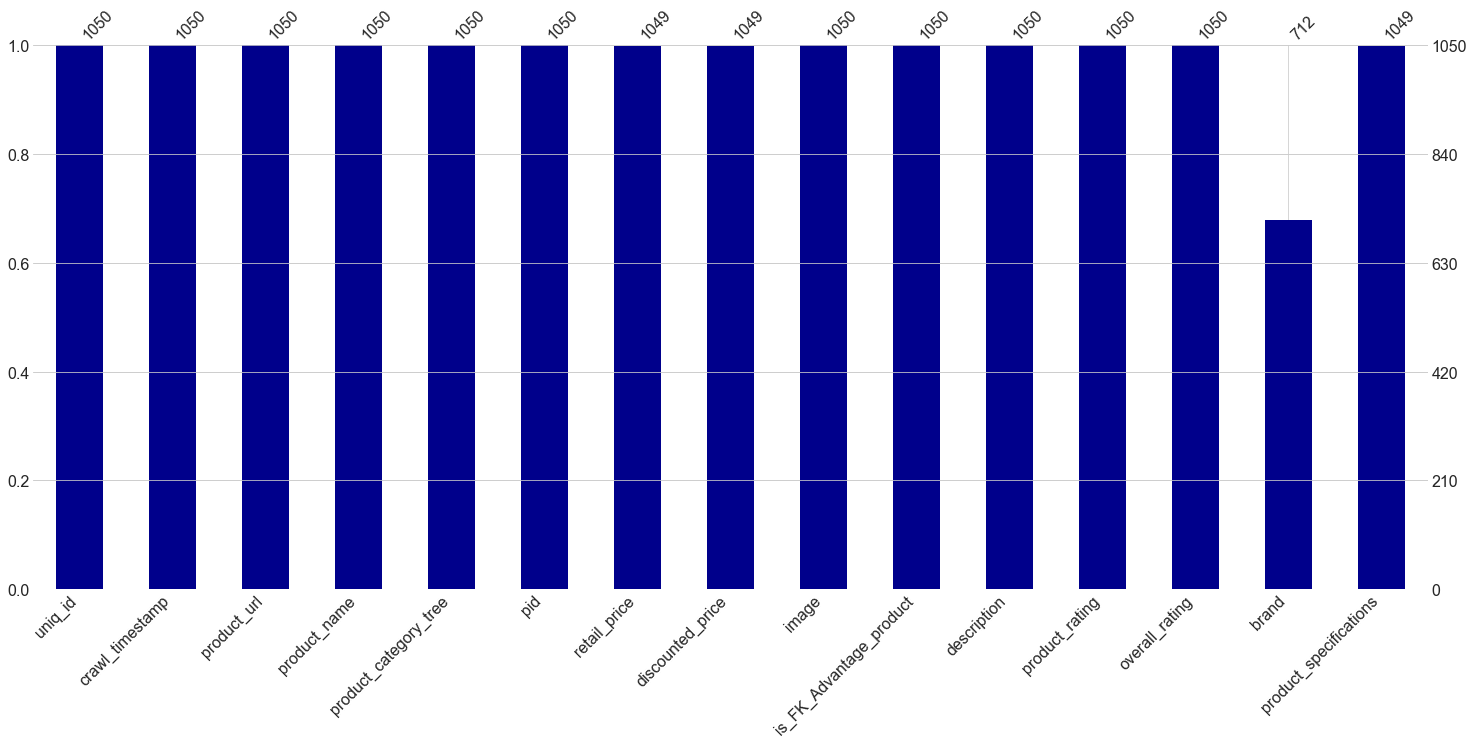

In [3]:
msno.bar(df_articles, color="darkblue")
plt.show()

In [4]:
taux_remp = 100*(1-df_articles.isnull().sum().sum()
                 / (df_articles.shape[0]*df_articles.shape[1]))
print('Le dataset présente un taux de remplissage de '
      + str(round(taux_remp)) + '%.')

Le dataset présente un taux de remplissage de 98%.


Les variables intéressantes pour notre étude sont :
- ```product_name``` pour récupérer le nom du produit,
- ```product_category_tree``` pour connaître la catégorie du produit,
- ```description``` pour prédire la catégorie,
- ```image``` pour retrouver l'image correspondante à l'article.

In [5]:
df_ = df_articles[['product_name', 'product_category_tree',
                   'image', 'description']]
df_.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

[Retour au sommaire](#Sommaire)
### Nettoyage des données textuelles <a class="anchor" id="Partie1_2"></a>

In [6]:
def Nettoyage(texte, print_):
    if print_:
        print('Phrase initiale :')
        print(texte)
        print()

    # Normalisation
    texte_ = texte.lower()
    if print_:
        print('Après normalisation :')
        print(texte_)
        print()

    # Tokénisation
    texte_ = word_tokenize(texte_)
    if print_:
        print('Après tokénisation :')
        print(texte_)
        print()

    # Suppression des stop words
    stopW = stopwords.words('english')
    exclude = set(string.punctuation)
    stopW.extend(exclude)
    texte_ = [word for word in texte_ if word not in stopW]
    if print_:
        print('Après suppression des stop words :')
        print(texte_)
        print()

    # Lemmatization (ou Stemming)
    lemma = WordNetLemmatizer()
    texte_ = [lemma.lemmatize(lemma.lemmatize(
        lemma.lemmatize(word, pos='a'), pos='v'), pos='n') for word in texte_]
    if print_:
        print('Après lemmatization :')
        print(texte_)
        print()

    # Jointure des mots
    texte_ = ' '.join(word for word in texte_)
    if print_:
        print('Phrase finale :')
        print(texte_)
        print()

    return texte_

In [7]:
Phrase = df_['description'].iloc[0]
# 'This is a group of several words for preprocessing !'
Phrase_nettoyee = Nettoyage(Phrase, True)

Phrase initiale :
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [8]:
df_['description'] = df_['description'].apply(lambda x: Nettoyage(x, False))
df_['product_name'] = df_['product_name'].apply(lambda x: Nettoyage(x, False))

[Retour au sommaire](#Sommaire)
### Gestion des catégories <a class="anchor" id="Partie1_3"></a>

In [9]:
len(df_['product_category_tree'].unique())

642

In [10]:
def main_category(cat):
    index = cat.find(' >>')
    main_cat = cat[2:index]
    return main_cat

In [11]:
df_['Catégorie'] = df_['product_category_tree'].apply(
    lambda x: main_category(x))
df_['Catégorie'] = df_['Catégorie'].astype('category')
le = preprocessing.LabelEncoder()
df_['Catégorie Numérique'] = le.fit_transform(df_['Catégorie'])
Categories = df_['Catégorie'].unique()
Categories_num = df_['Catégorie Numérique']

print('Catégorie avant traitement :', df_['product_category_tree'][12])
print('\nCatégorie après traitement :', df_['Catégorie'][12])

df_.drop(['product_category_tree'], axis=1, inplace=True)
df_.head()

Catégorie avant traitement : ["Watches >> Wrist Watches >> Lois Caron Wrist Watches"]

Catégorie après traitement : Watches


product_name  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   
2                eurospa cotton terry face towel set   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size double be...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description        Catégorie  \
0  key feature elegance polyester multicolor abst...  Home Furnishing   
1  specification sathiyas cotton bath towel 3 bat...        Baby Care   
2  key feature eurospa cotton terry face towel se...        Baby Care   
3  key feature santosh royal fashion cotton print...  Home Furnishing   
4  key feature jaipur print cotton floral king si...  Home Furnishing   

   Catégorie Numérique  
0                    4  
1                    0  
2                    0  
3                    4  
4                    4

In [12]:
len(df_['Catégorie'].unique())

7

### WordCloud

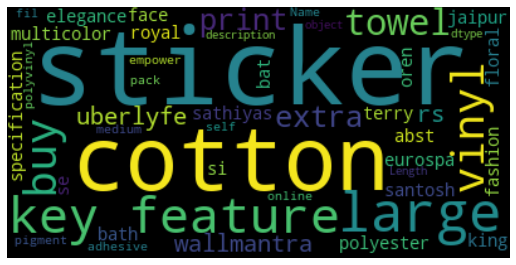

In [13]:
# WordCloud pour 'description'
# Instantiate a new wordcloud.
wordcloud = WordCloud()

# Apply the wordcloud to the text.
wordcloud.generate(str(df_['description']))

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud, interpolation='bilinear')
# and remove the axis
plt.axis("off")
plt.show()

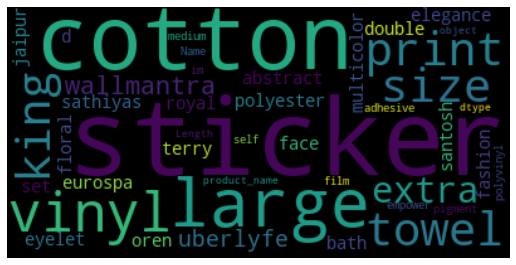

In [14]:
# WordCloud pour 'product_name'
wordcloud = WordCloud()
wordcloud.generate(str(df_['product_name']))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[Retour au sommaire](#Sommaire)
### Approche Bag Of Words <a class="anchor" id="Partie1_4"></a>

* [CountVectorizer](#PartieA)
    * [Seulement avec la description](#PartieA_1)
    * [Avec la description et le nom de l'article](#PartieA_2)
    * [Seulement avec le nom](#PartieA_3)
* [Tf-Idf](#PartieB)
    * [Seulement avec la description](#PartieB_1)
    * [Avec la description et le nom de l'article](#PartieB_2)
    * [Seulement avec le nom](#PartieB_3)
* [Comparaison des performances](#PartieC)
* [Count Vectorizer et Tf-idf pour la phrase d'exemple](#PartieD)

In [15]:
def ACP(df, n_comp=0.9):
    # ACP
    X = df.iloc[:, :-1].values
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)

    # Eboulis des valeurs propres
    scree = pca.explained_variance_ratio_*100
    plt.figure()
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red', marker='o')
    plt.xlabel('Rang de l\'axe d\'inertie')
    plt.ylabel('Pourcentage d\'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.show(block=False)

    X_projected = pca.transform(X_scaled)
    df_ACP = pd.DataFrame(X_projected)

    for d1, d2 in [(0, 1), (2, 3)]:
        plt.figure(figsize=(7, 6))
        # détermination des limites du graphique
        boundary = np.mean(np.abs(X_projected[:, [d1, d2]])) * 1.1
        # boundary = 100
        plt.xlim([-boundary, boundary])
        plt.ylim([-boundary, boundary])

        # affichage des lignes horizontales et verticales
        plt.plot([-100, 100], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-100, 100], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1+1, round(
            100*pca.explained_variance_ratio_[d1], 1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(
            100*pca.explained_variance_ratio_[d2], 1)))

        for cat in df['Catégorie'].unique():
            df_cat = df[df['Catégorie'] == cat]
            data_pca_cat = df_cat.drop(df_cat.columns[-1], axis=1)
            X_cat = data_pca_cat.values
            X_scaled_cat = std_scale.transform(X_cat)
            X_projected_cat = pca.transform(X_scaled_cat)
            # affichage des points
            plt.scatter(X_projected_cat[:, d1], X_projected_cat[:, d2],
                        alpha=1, label=cat)

        plt.title("Projection des individus (sur F{} et F{})".format(
            d1+1, d2+1))
        plt.legend(loc='best', title='Catégorie')
        plt.show()
    return df_ACP

In [16]:
def ARI(X_tsne, df_):
    cls = KMeans(n_clusters=7, random_state=6)
    cls.fit(X_tsne)
    labels_ = cls.labels_

    labels = df_['Catégorie']
    ARI = metrics.adjusted_rand_score(labels, labels_)
    print('ARI :', ARI)
    return ARI, labels_

In [17]:
def AfficheClusters(X_tsne, df_, labels):
    fig = plt.figure(figsize=(16, 8))

    ax = fig.add_subplot(121)
    ax = sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1],
                         hue=df_['Catégorie'])
    plt.title('Représentation des articles par catégories réelles')

    ax = fig.add_subplot(122)
    ax = sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels,
                         palette=sns.color_palette('Set1', n_colors=7))
    ax.legend(loc='best', title='Clusters')
    plt.title('Représentation des articles par clusters')

    plt.show()

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

#### Comptage de mots (CountVectorizer) <a class="anchor" id="PartieA"></a>
1. Seulement avec la description <a class="anchor" id="PartieA_1"></a>

In [18]:
count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_count = count_vect.fit_transform(df_['description'])
df_count = pd.DataFrame(X_count.toarray())
df_count.columns = count_vect.get_feature_names_out()
df_count['Catégorie'] = df_['Catégorie']
print(df_count.shape)
df_count.head()

(1050, 5244)


00  000  001  0021  004  005  006  0083  01  011  ...  zinc  zingalalaa  \
0   0    0    0     0    0    0    0     0   0    0  ...     0           0   
1   0    0    0     0    0    0    0     0   0    0  ...     0           0   
2   0    0    0     0    0    0    0     0   0    0  ...     0           0   
3   0    0    0     0    0    0    0     0   0    0  ...     0           0   
4   0    0    0     0    0    0    0     0   0    0  ...     0           0   

   zip  zipexterior  zipper  zone  zoom  zora  zyxel        Catégorie  
0    0            0       0     0     0     0      0  Home Furnishing  
1    0            0       0     0     0     0      0        Baby Care  
2    0            0       0     0     0     0      0        Baby Care  
3    0            0       0     0     0     0      0  Home Furnishing  
4    0            0       0     0     0     0      0  Home Furnishing  

[5 rows x 5244 columns]

In [19]:
def select_frequences(df, nb):
    A = pd.DataFrame(df.sum())
    B = A[A[0] >= nb]
    liste_colonnes = B.index.to_list()
    liste_colonnes.append('Catégorie')
    return df[liste_colonnes]

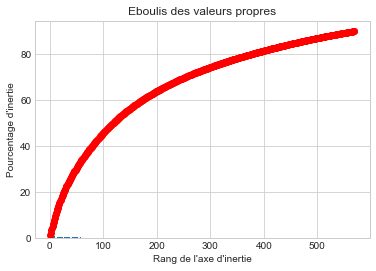

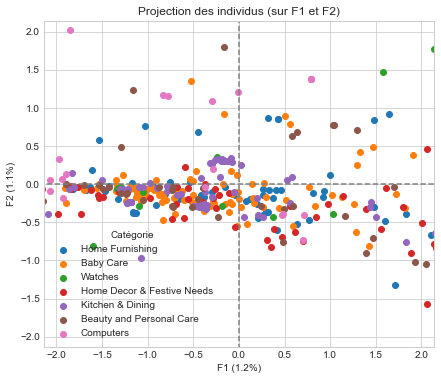

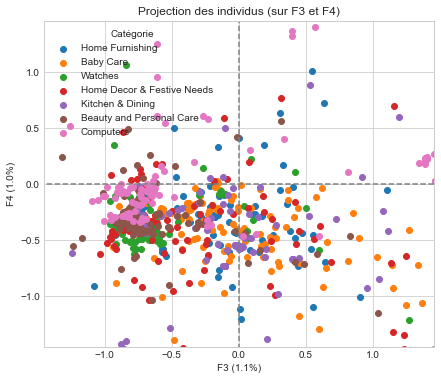

In [20]:
# ACP
df_ACP_count = ACP(df_count)

ARI : 0.40423319134682983


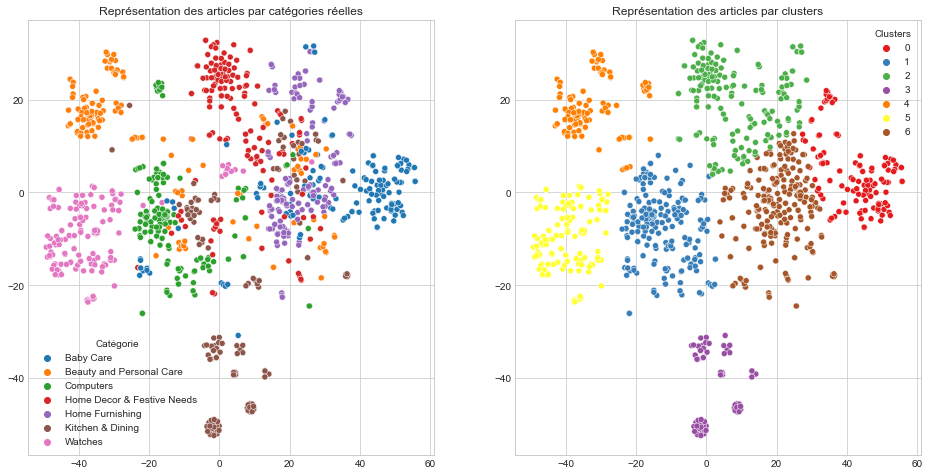

In [21]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_count = tsne.fit_transform(df_count.iloc[:, :-1])
ARI_count, labels_count = ARI(X_tsne_count, df_)
AfficheClusters(X_tsne_count, df_, labels_count)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

2. Avec la description et le nom de l'article <a class="anchor" id="PartieA_2"></a>

In [22]:
df_['name + description'] = df_['product_name'] + ' ' + df_['description']
df_.head()

product_name  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   
2                eurospa cotton terry face towel set   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size double be...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description        Catégorie  \
0  key feature elegance polyester multicolor abst...  Home Furnishing   
1  specification sathiyas cotton bath towel 3 bat...        Baby Care   
2  key feature eurospa cotton terry face towel se...        Baby Care   
3  key feature santosh royal fashion cotton print...  Home Furnishing   
4  key feature jaipur print cotton floral king si...  Home Furnishing   

   Catégorie Numérique                                 name + description  
0                    4  elegance polyester multicolor abstract eyelet ...  
1                    0  sathiyas cotton bath towel specification sathi...  
2                    0  eurospa cotton terry face towel set key featur...  
3                    4  santosh royal fashion cotton print king size d...  
4                    4  jaipur print cotton floral king size double be...

In [23]:
count_vect2 = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_count2 = count_vect2.fit_transform(df_['name + description'])
df_count2 = pd.DataFrame(X_count2.toarray())
df_count2.columns = count_vect2.get_feature_names_out()
df_count2['Catégorie'] = df_['Catégorie']
print(df_count2.shape)
df_count2.head()

(1050, 5244)


00  000  001  0021  004  005  006  0083  01  011  ...  zinc  zingalalaa  \
0   0    0    0     0    0    0    0     0   0    0  ...     0           0   
1   0    0    0     0    0    0    0     0   0    0  ...     0           0   
2   0    0    0     0    0    0    0     0   0    0  ...     0           0   
3   0    0    0     0    0    0    0     0   0    0  ...     0           0   
4   0    0    0     0    0    0    0     0   0    0  ...     0           0   

   zip  zipexterior  zipper  zone  zoom  zora  zyxel        Catégorie  
0    0            0       0     0     0     0      0  Home Furnishing  
1    0            0       0     0     0     0      0        Baby Care  
2    0            0       0     0     0     0      0        Baby Care  
3    0            0       0     0     0     0      0  Home Furnishing  
4    0            0       0     0     0     0      0  Home Furnishing  

[5 rows x 5244 columns]

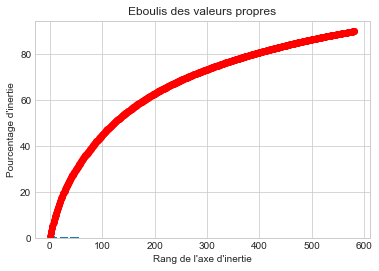

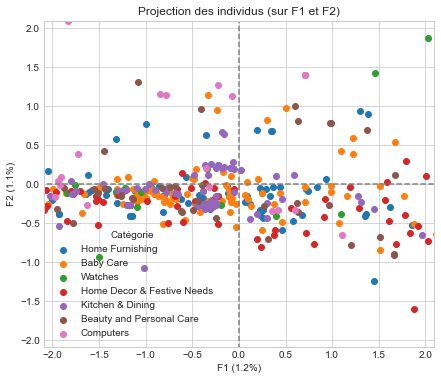

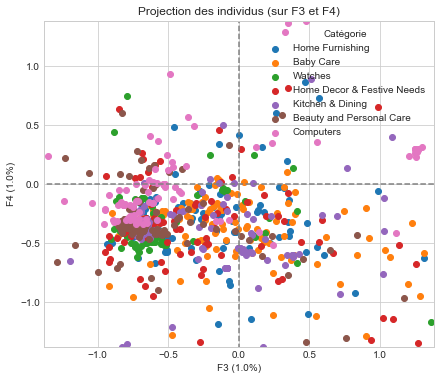

In [24]:
# ACP
df_ACP_count2 = ACP(df_count2)

ARI : 0.449793734714023


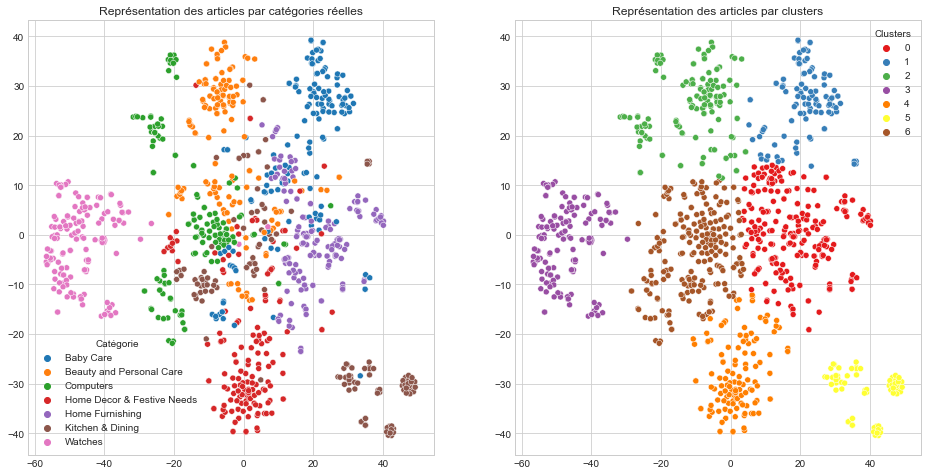

In [25]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_count2 = tsne.fit_transform(df_count2.iloc[:, :-1])
ARI_count2, labels_count2 = ARI(X_tsne_count2, df_)
AfficheClusters(X_tsne_count2, df_, labels_count2)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

3. Seulement avec le nom du produit <a class="anchor" id="PartieA_3"></a>

In [26]:
count_vect3 = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_count3 = count_vect3.fit_transform(df_['product_name'])
df_count3 = pd.DataFrame(X_count3.toarray())
df_count3.columns = count_vect3.get_feature_names_out()
df_count3['Catégorie'] = df_['Catégorie']
print(df_count3.shape)
df_count3.head()

(1050, 2246)


001  005  006  01  011  01433cmgy  01727lpln  01741lpln  01784bmly  \
0    0    0    0   0    0          0          0          0          0   
1    0    0    0   0    0          0          0          0          0   
2    0    0    0   0    0          0          0          0          0   
3    0    0    0   0    0          0          0          0          0   
4    0    0    0   0    0          0          0          0          0   

   03918cmly  ...  yuva  yves  zaicus  zero  zikrak  zingalalaa  zone  zora  \
0          0  ...     0     0       0     0       0           0     0     0   
1          0  ...     0     0       0     0       0           0     0     0   
2          0  ...     0     0       0     0       0           0     0     0   
3          0  ...     0     0       0     0       0           0     0     0   
4          0  ...     0     0       0     0       0           0     0     0   

   zyxel        Catégorie  
0      0  Home Furnishing  
1      0        Baby Care  
2      0        Baby Care  
3      0  Home Furnishing  
4      0  Home Furnishing  

[5 rows x 2246 columns]

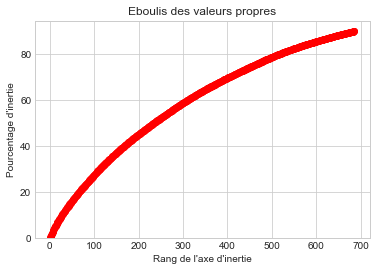

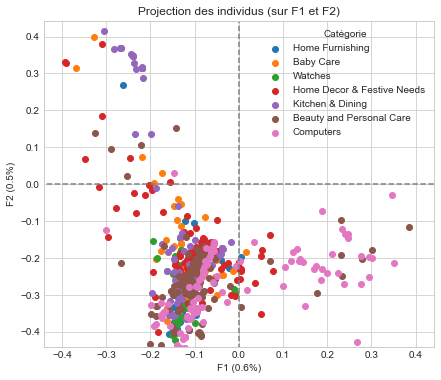

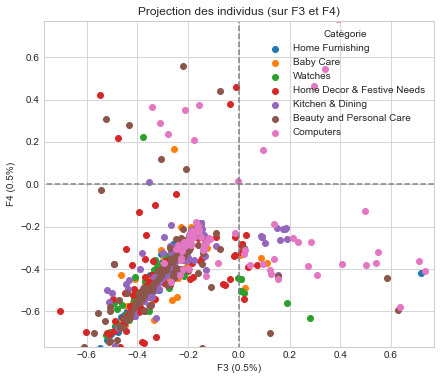

In [27]:
# ACP
df_ACP_count3 = ACP(df_count3)

ARI : 0.3715241375607889


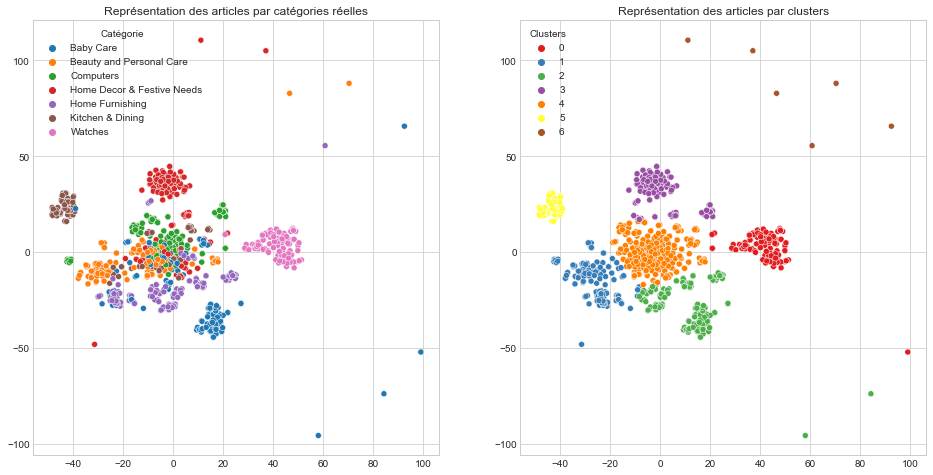

In [28]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_count3 = tsne.fit_transform(df_count3.iloc[:, :-1])
ARI_count3, labels_count3 = ARI(X_tsne_count3, df_)
AfficheClusters(X_tsne_count3, df_, labels_count3)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

#### Tf-Idf <a class="anchor" id="PartieB"></a>
1. Seulement avec la description <a class="anchor" id="PartieB_1"></a>

In [29]:
vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_mat = vect.fit_transform(df_['description'])
feature_names = vect.get_feature_names()
dense = tfidf_mat.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)
df_tfidf['Catégorie'] = df_['Catégorie']
print(df_tfidf.shape)
df_tfidf.head()

(1050, 5244)


00  000  001  0021  004  005  006  0083   01  011  ...  zinc  zingalalaa  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   

   zip  zipexterior  zipper  zone  zoom  zora  zyxel        Catégorie  
0  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  
1  0.0          0.0     0.0   0.0   0.0   0.0    0.0        Baby Care  
2  0.0          0.0     0.0   0.0   0.0   0.0    0.0        Baby Care  
3  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  
4  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  

[5 rows x 5244 columns]

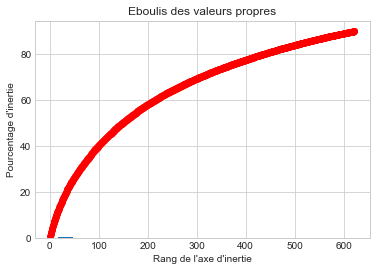

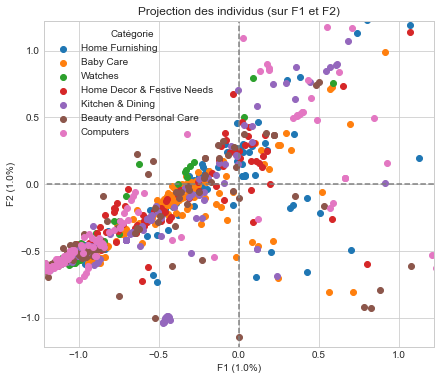

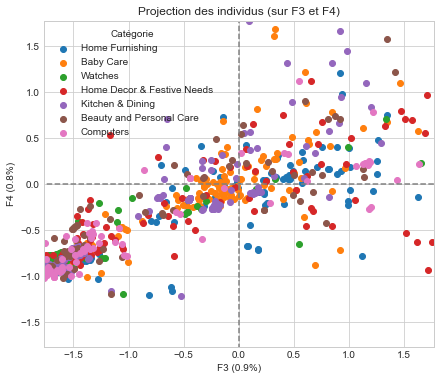

In [30]:
# ACP
df_ACP_tfidf = ACP(df_tfidf)

ARI : 0.5524589284539855


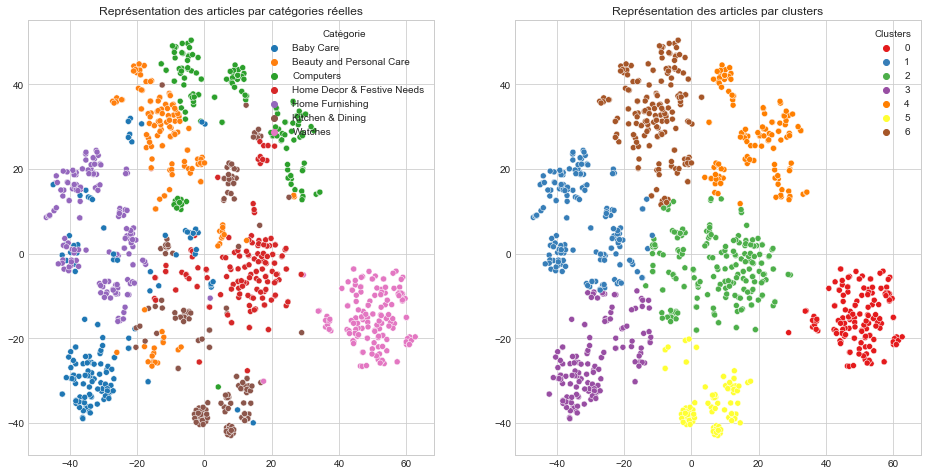

In [31]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_tfidf = tsne.fit_transform(df_tfidf.iloc[:, :-1])
ARI_tfidf, labels_tfidf = ARI(X_tsne_tfidf, df_)
AfficheClusters(X_tsne_tfidf, df_, labels_tfidf)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

2. Avec la description et le nom de l'article <a class="anchor" id="PartieB_2"></a>

In [32]:
vect2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_mat2 = vect2.fit_transform(df_['name + description'])
feature_names2 = vect2.get_feature_names()
dense2 = tfidf_mat2.todense()
denselist2 = dense2.tolist()
df_tfidf2 = pd.DataFrame(denselist2, columns=feature_names2)
df_tfidf2['Catégorie'] = df_['Catégorie']
print(df_tfidf2.shape)
df_tfidf2.head()

(1050, 5244)


00  000  001  0021  004  005  006  0083   01  011  ...  zinc  zingalalaa  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0         0.0   

   zip  zipexterior  zipper  zone  zoom  zora  zyxel        Catégorie  
0  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  
1  0.0          0.0     0.0   0.0   0.0   0.0    0.0        Baby Care  
2  0.0          0.0     0.0   0.0   0.0   0.0    0.0        Baby Care  
3  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  
4  0.0          0.0     0.0   0.0   0.0   0.0    0.0  Home Furnishing  

[5 rows x 5244 columns]

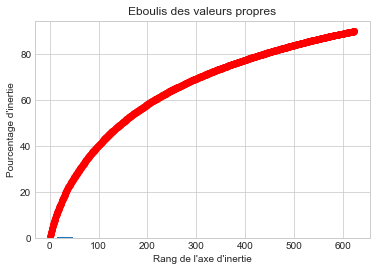

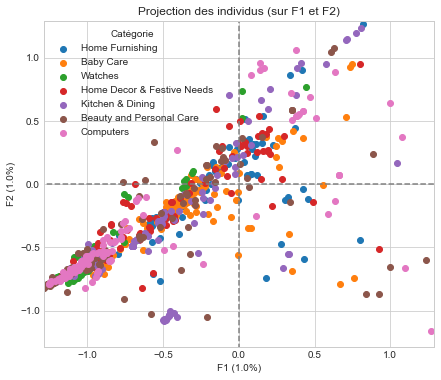

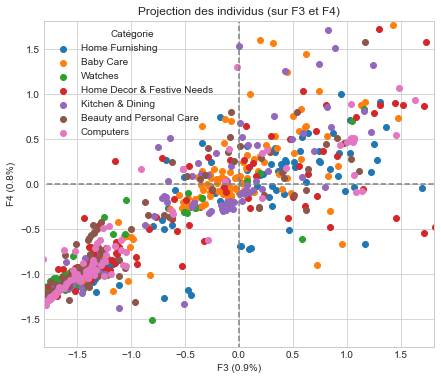

In [33]:
# ACP
df_ACP_tfidf2 = ACP(df_tfidf2)

ARI : 0.5478588171821691


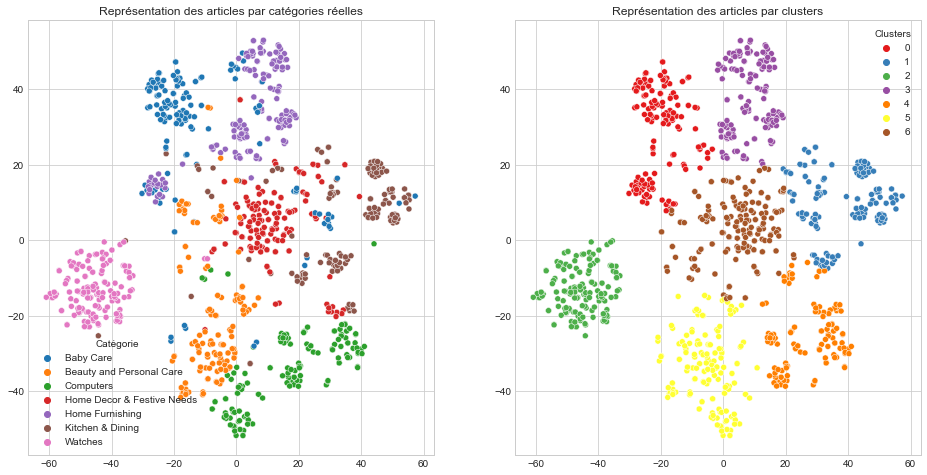

In [34]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_tfidf2 = tsne.fit_transform(df_tfidf2.iloc[:, :-1])
ARI_tfidf2, labels_tfidf2 = ARI(X_tsne_tfidf2, df_)
AfficheClusters(X_tsne_tfidf2, df_, labels_tfidf2)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

3. Seulement avec le nom du produit <a class="anchor" id="PartieB_3"></a>

In [35]:
vect3 = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_mat3 = vect3.fit_transform(df_['product_name'])
feature_names3 = vect3.get_feature_names()
dense3 = tfidf_mat3.todense()
denselist3 = dense3.tolist()
df_tfidf3 = pd.DataFrame(denselist3, columns=feature_names3)
df_tfidf3['Catégorie'] = df_['Catégorie']
print(df_tfidf3.shape)
df_tfidf3.head()

(1050, 2246)


001  005  006   01  011  01433cmgy  01727lpln  01741lpln  01784bmly  \
0  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0        0.0   
1  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0        0.0   
2  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0        0.0   
3  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0        0.0   
4  0.0  0.0  0.0  0.0  0.0        0.0        0.0        0.0        0.0   

   03918cmly  ...  yuva  yves  zaicus  zero  zikrak  zingalalaa  zone  zora  \
0        0.0  ...   0.0   0.0     0.0   0.0     0.0         0.0   0.0   0.0   
1        0.0  ...   0.0   0.0     0.0   0.0     0.0         0.0   0.0   0.0   
2        0.0  ...   0.0   0.0     0.0   0.0     0.0         0.0   0.0   0.0   
3        0.0  ...   0.0   0.0     0.0   0.0     0.0         0.0   0.0   0.0   
4        0.0  ...   0.0   0.0     0.0   0.0     0.0         0.0   0.0   0.0   

   zyxel        Catégorie  
0    0.0  Home Furnishing  
1    0.0        Baby Care  
2    0.0        Baby Care  
3    0.0  Home Furnishing  
4    0.0  Home Furnishing  

[5 rows x 2246 columns]

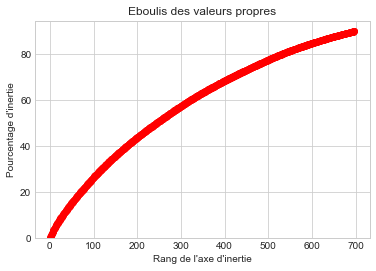

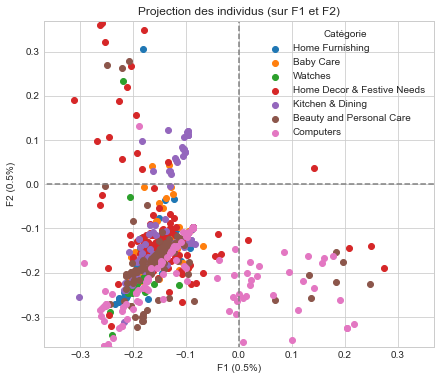

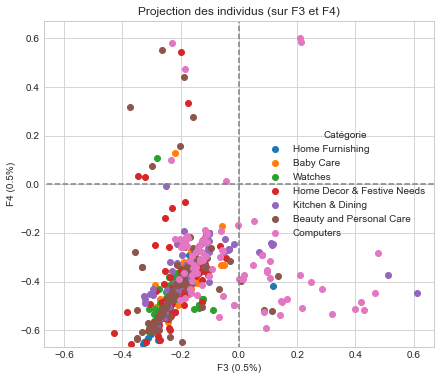

In [36]:
# ACP
df_ACP_tfidf3 = ACP(df_tfidf3)

ARI : 0.46916733449925624


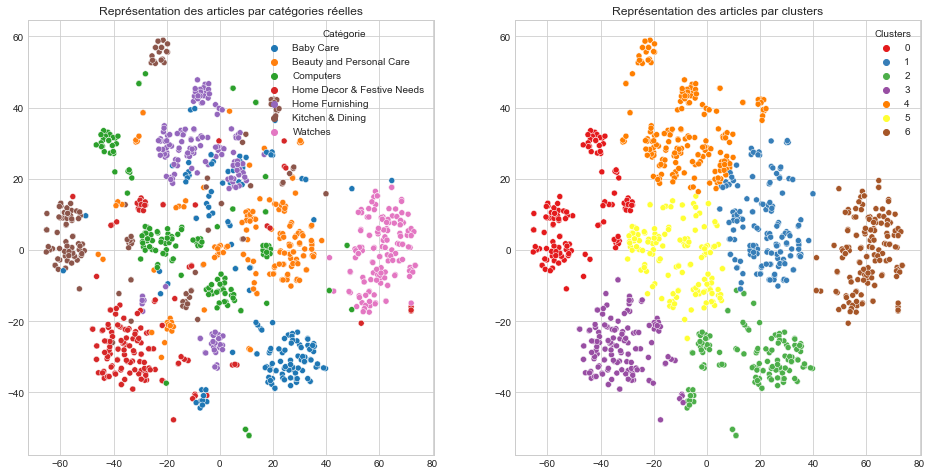

In [37]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_tfidf3 = tsne.fit_transform(df_tfidf3.iloc[:, :-1])
ARI_tfidf3, labels_tfidf3 = ARI(X_tsne_tfidf3, df_)
AfficheClusters(X_tsne_tfidf3, df_, labels_tfidf3)

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

#### Comparaison des performances <a class="anchor" id="PartieC"></a>

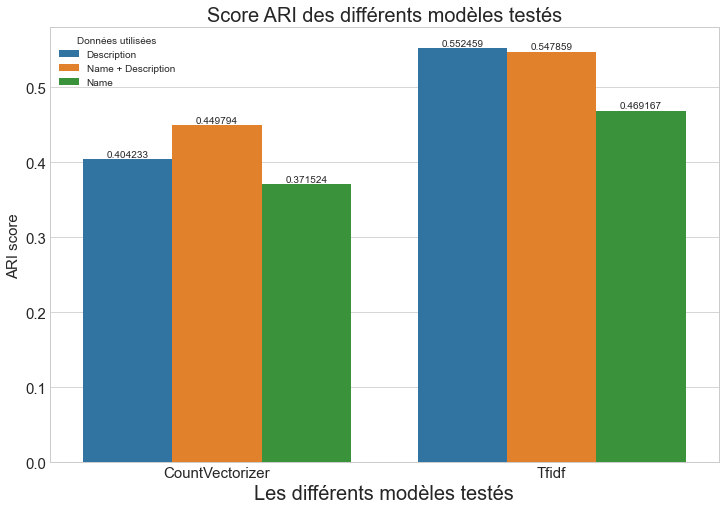

In [38]:
listeARI = [ARI_count, ARI_count2, ARI_count3,
            ARI_tfidf, ARI_tfidf2, ARI_tfidf3]
listeDonnees = ['Description', 'Name + Description', 'Name',
                'Description', 'Name + Description', 'Name']
listeModeles = ['CountVectorizer', 'CountVectorizer', 'CountVectorizer',
                'Tfidf', 'Tfidf', 'Tfidf']
score = pd.DataFrame()
score['Modèle'] = listeModeles
score['ARI'] = listeARI
score['Données utilisées'] = listeDonnees

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Modèle', y='ARI', hue='Données utilisées', data=score)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Score ARI des différents modèles testés',
          fontsize=20)
plt.xlabel('Les différents modèles testés', fontsize=20)
plt.ylabel('ARI score', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xticks(rotation=45)
plt.show()

[Retour au sommaire - Approche Bag Of Words](#Partie1_4)

#### Count Vectorizer et Tf-Idf pour la phrase d'exemple <a class="anchor" id="PartieD"></a>

In [39]:
lst = ['This is an example for preprocessing.',
       'Several sentences for preprocessing,',
       'And the third sentence !']
print(lst)
df_ex = pd.DataFrame(lst, columns=['text'])
df_ex['text'] = df_ex['text'].apply(lambda x: Nettoyage(x, False))

count_vect_ex = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_count_ex = count_vect_ex.fit_transform(df_ex['text'])
df_count_ex = pd.DataFrame(X_count_ex.toarray())
df_count_ex.columns = count_vect_ex.get_feature_names_out()
print(df_count_ex.shape)
df_count_ex.head()

['This is an example for preprocessing.', 'Several sentences for preprocessing,', 'And the third sentence !']
(3, 5)


example  preprocessing  sentence  several  third
0        1              1         0        0      0
1        0              1         1        1      0
2        0              0         1        0      1

In [40]:
vect_ex = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_mat_ex = vect_ex.fit_transform(df_ex['text'])
feature_names_ex = vect_ex.get_feature_names()
dense_ex = tfidf_mat_ex.todense()
denselist_ex = dense_ex.tolist()
df_tfidf_ex = pd.DataFrame(denselist_ex, columns=feature_names_ex)
print(df_tfidf_ex.shape)
df_tfidf_ex.head()

(3, 5)


example  preprocessing  sentence   several     third
0  0.795961       0.605349  0.000000  0.000000  0.000000
1  0.000000       0.517856  0.517856  0.680919  0.000000
2  0.000000       0.000000  0.605349  0.000000  0.795961

[Retour au sommaire](#Sommaire)

### Sentence embedding <a class="anchor" id="Partie1_5"></a>

* [Word2vec](#PartieE)
    * [Seulement avec la description](#PartieE_1)
    * [Avec la description et le nom de l'article](#PartieE_2)
* [BERT](#PartieF)
    * [Seulement avec la description](#PartieF_1)
    * [Avec la description et le nom de l'article](#PartieF_2)
* [USE](#PartieG)
    * [Seulement avec la description](#PartieG_1)
    * [Avec la description et le nom de l'article](#PartieG_2)
* [Comparaison des performances](#PartieH)


#### Word2vec <a class="anchor" id="PartieE"></a>
1. Seulement avec la description <a class="anchor" id="PartieE_1"></a>

In [41]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
sentences = df_['description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
maxlen = 24  # adapt to length of sentences

In [42]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size, seed=42, workers=1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)

# Matrice des vecteurs de chacun des mots du dataset
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4385
Word2Vec trained


In [43]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(
    tokenizer.texts_to_sequences(sentences),
    # Crée un array de 1050 lignes : 1 ligne par article
    # Pour chaque article on remplace chaque mot de la description
    # par son index dans le vocabulaire
    maxlen=maxlen, padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4386


In [44]:
# Création de la matrice d'embedding
# Matrice des vecteurs de chacun des mots du dictionnaire
# On supprime donc les mots qui apparaissent moins de 'w2v_min_count' fois

print("Create Embedding matrix ...")

# Dictionnaire des mots du dataset avec leurs index
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4386, 300)


In [45]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size, output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1315800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,315,800
Trainable params: 1,315,800
Non-trainable params: 0
_________________________________________________________________


In [46]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 300)

In [47]:
pd.DataFrame(embeddings).head()

0         1         2         3         4         5         6    \
0 -0.678433 -0.147758 -0.174126  0.291170 -0.740631 -0.757100  0.238956   
1 -0.480693  0.251858 -0.610138  0.042536 -0.623376 -0.765138  0.465081   
2 -0.443794  0.094580 -0.319883  0.144896 -0.332652 -0.590861  0.404715   
3 -0.939404  0.120674 -0.425628  0.186176 -0.595801 -0.441929  0.687847   
4 -0.906123  0.132861 -0.397450  0.270416 -0.550795 -0.416467  0.749971   

        7         8         9    ...       290       291       292       293  \
0 -0.633848  0.776741 -0.623508  ... -0.600677  0.586663 -0.066676  0.932004   
1 -0.659608  0.680029 -0.583473  ... -0.299923  0.564973  0.109789  0.972068   
2 -0.514023  0.635264 -0.500071  ... -0.355366  0.489714 -0.137357  0.858245   
3 -0.843124  0.785453 -1.188132  ... -0.173394  0.296330 -0.334809  0.998140   
4 -0.761182  0.815314 -1.181772  ... -0.038300  0.349093 -0.285293  1.103191   

        294       295       296       297       298       299  
0 -0.228388 -0.551403 -0.284550 -0.433055 -0.157132  0.028116  
1  0.099316 -0.404745 -0.235509 -0.722625 -0.160233  0.316984  
2 -0.011643 -0.250630 -0.192711 -0.939862 -0.202814  0.113427  
3  0.759735 -0.226132 -0.270056 -0.500689 -0.136585  0.119289  
4  0.804750 -0.263689 -0.355077 -0.530749 -0.131537  0.091932  

[5 rows x 300 columns]

ARI : 0.21172846287940447


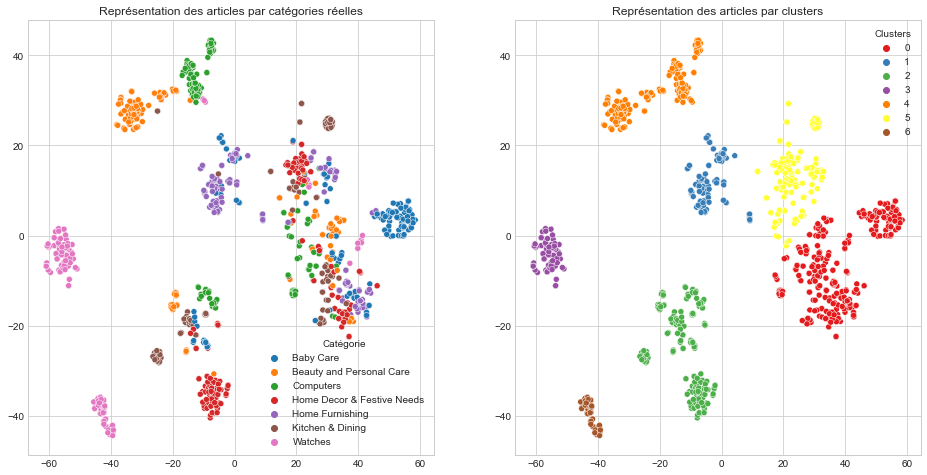

In [48]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_w2v = tsne.fit_transform(embeddings)
ARI_w2v, labels_w2v = ARI(X_tsne_w2v, df_)
AfficheClusters(X_tsne_w2v, df_, labels_w2v)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

2. Avec la description et le nom de l'article <a class="anchor" id="PartieE_2"></a>

In [49]:
sentences2 = df_['name + description'].to_list()
sentences2 = [gensim.utils.simple_preprocess(text) for text in sentences2]

# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size, seed=42, workers=1)
w2v_model.build_vocab(sentences2)
w2v_model.train(sentences2, total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")


print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences2)
x_sentences2 = pad_sequences(tokenizer.texts_to_sequences(sentences2),
                             maxlen=maxlen, padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

# Création du modèle
input = Input(shape=(len(x_sentences2), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

embeddings2 = embed_model.predict(x_sentences2)
embeddings2.shape

Build & train Word2Vec model ...
Vocabulary size: 4385
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 4386
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4386, 300)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1315800   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,315,800
Trainable params: 1,315,800
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s

(1050, 300)

ARI : 0.2527900893463831


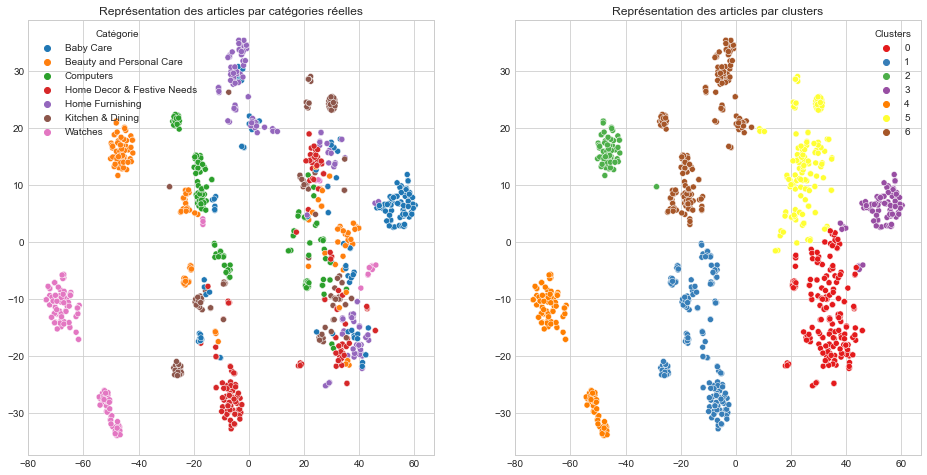

In [50]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_w2v2 = tsne.fit_transform(embeddings2)
ARI_w2v2, labels_w2v2 = ARI(X_tsne_w2v2, df_)
AfficheClusters(X_tsne_w2v2, df_, labels_w2v2)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

#### BERT <a class="anchor" id="PartieF"></a>
1. Seulement avec la description <a class="anchor" id="PartieF_1"></a>

In [51]:
os.environ["TF_KERAS"] = '1'

print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [52]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length,
                     b_size, mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        list_ = bert_inp_fct(sentences[idx:idx+batch_size], bert_tokenizer,
                             max_length)
        [input_ids, token_type_ids, attention_mask, bert_inp_tot] = list_

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids],
                batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    return features_bert, last_hidden_states_tot

In [53]:
hf_logging.set_verbosity_error()

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_['description'].to_list()

In [54]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, sentences, max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step


ARI : 0.33006707865640145


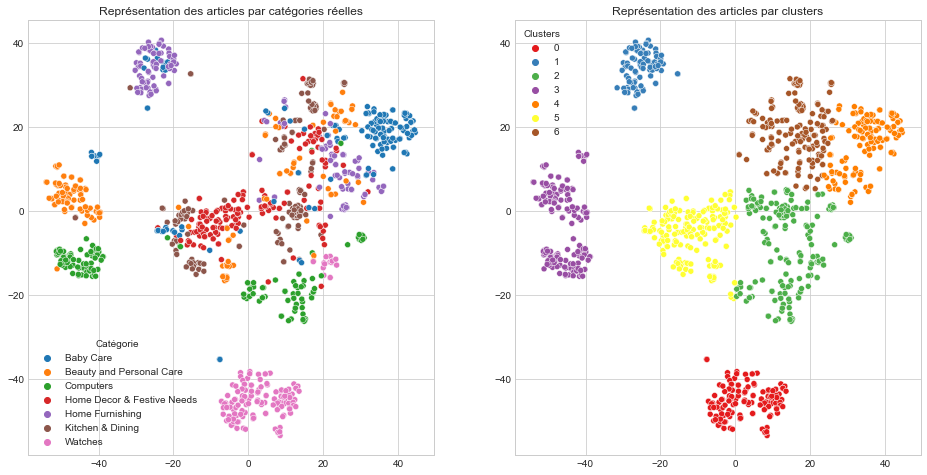

In [55]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_bert = tsne.fit_transform(features_bert)
ARI_bert, labels_bert = ARI(X_tsne_bert, df_)
AfficheClusters(X_tsne_bert, df_, labels_bert)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

2. Avec la description et le nom de l'article <a class="anchor" id="PartieF_2"></a>

In [56]:
sentences2 = df_['name + description'].to_list()

# Création des features
features_bert2, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, sentences2, max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step


ARI : 0.3935336379604598


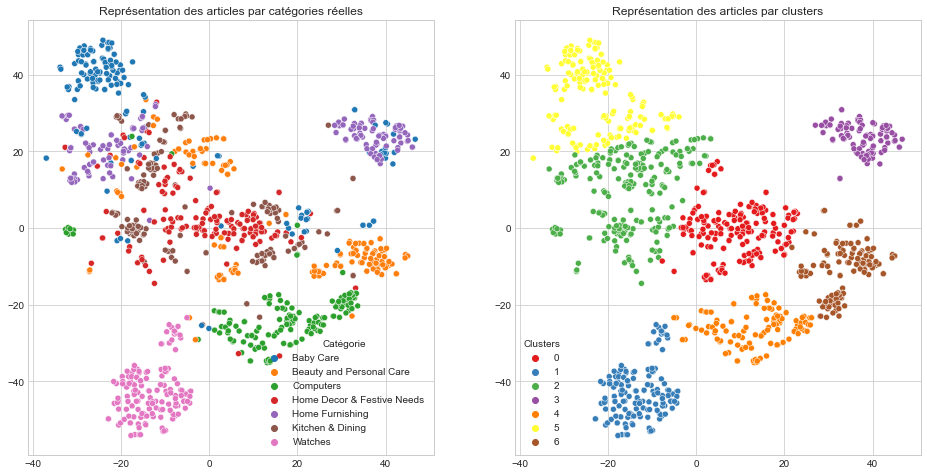

In [57]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_bert2 = tsne.fit_transform(features_bert2)
ARI_bert2, labels_bert2 = ARI(X_tsne_bert2, df_)
AfficheClusters(X_tsne_bert2, df_, labels_bert2)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

#### USE <a class="anchor" id="PartieG"></a>

In [58]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
batch_size = 10

In [59]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))
    return features

1. Seulement avec la description <a class="anchor" id="PartieG_1"></a>

In [60]:
sentences = df_['description'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

ARI : 0.46454061038770417


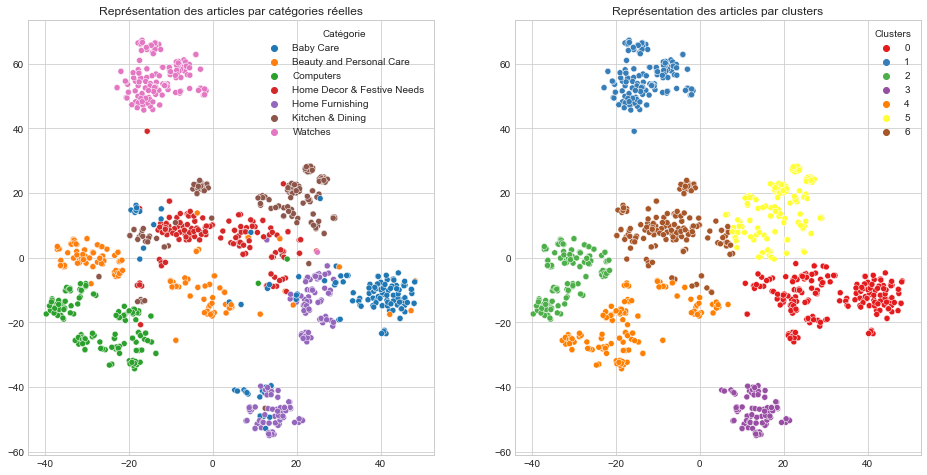

In [61]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_use = tsne.fit_transform(features_USE)
ARI_use, labels_use = ARI(X_tsne_use, df_)
AfficheClusters(X_tsne_use, df_, labels_use)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

2. Avec la description et le nom de l'article <a class="anchor" id="PartieG_2"></a>

In [62]:
sentences2 = df_['name + description'].to_list()
features_USE2 = feature_USE_fct(sentences2, batch_size)

ARI : 0.7124914215553205


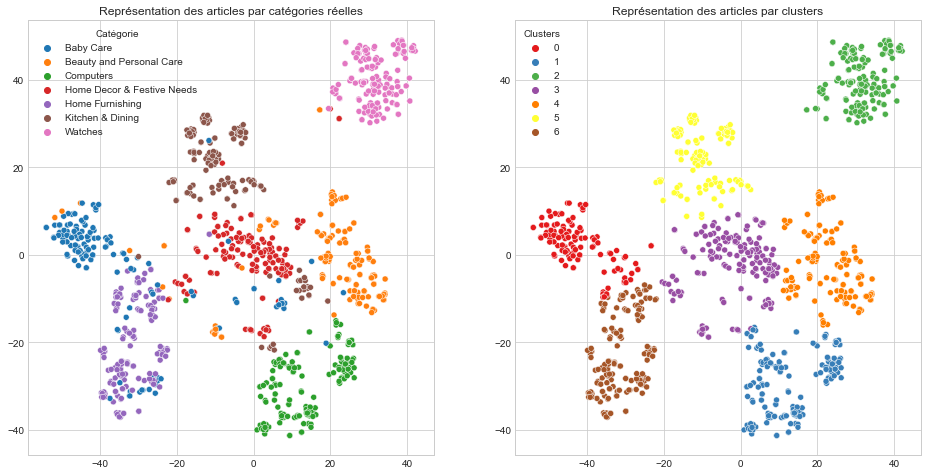

In [63]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_use2 = tsne.fit_transform(features_USE2)
ARI_use2, labels_use2 = ARI(X_tsne_use2, df_)
AfficheClusters(X_tsne_use2, df_, labels_use2)

[Retour au sommaire - Sentence embeddings](#Partie1_5)

#### Comparaison des performances <a class="anchor" id="PartieH"></a>

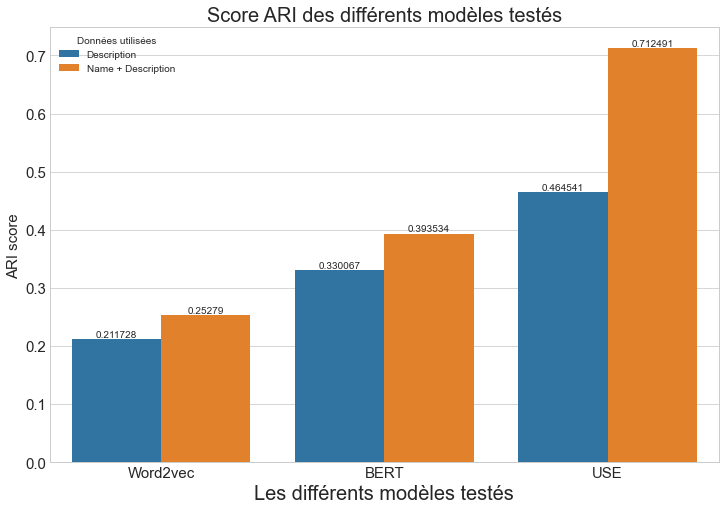

In [64]:
listeARI = [ARI_w2v, ARI_w2v2,
            ARI_bert, ARI_bert2,
            ARI_use, ARI_use2]
listeDonnees = ['Description', 'Name + Description',
                'Description', 'Name + Description',
                'Description', 'Name + Description']
listeModeles = ['Word2vec', 'Word2vec',
                'BERT', 'BERT', 'USE', 'USE']
score = pd.DataFrame()
score['Modèle'] = listeModeles
score['ARI'] = listeARI
score['Données utilisées'] = listeDonnees

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Modèle', y='ARI', hue='Données utilisées', data=score)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Score ARI des différents modèles testés',
          fontsize=20)
plt.xlabel('Les différents modèles testés', fontsize=20)
plt.ylabel('ARI score', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xticks(rotation=45)
plt.show()

[Retour au sommaire](#Sommaire)
## Données visuelles <a class="anchor" id="Partie2"></a>
### Chargement des images <a class="anchor" id="Partie2_1"></a>

In [65]:
path = "Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [66]:
# Création du dataset d'images
df_images = df_[['image', 'Catégorie', 'Catégorie Numérique']]
df_images.head()

image        Catégorie  Catégorie Numérique
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing                    4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care                    0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care                    0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing                    4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing                    4

Home Furnishing


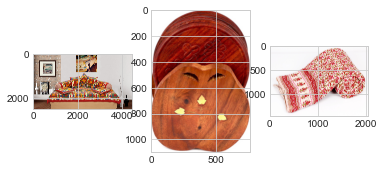

Baby Care


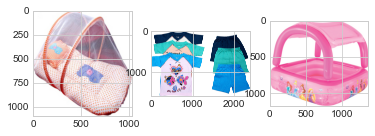

Watches


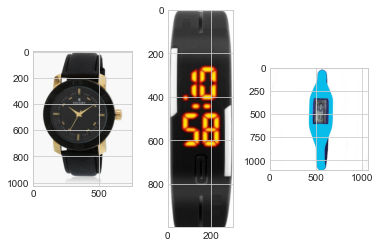

Home Decor & Festive Needs


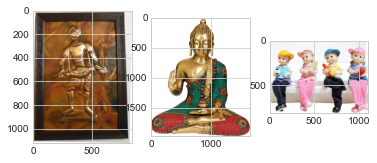

Kitchen & Dining


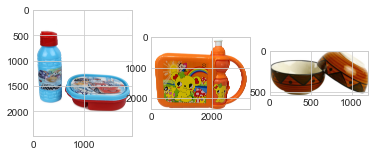

Beauty and Personal Care


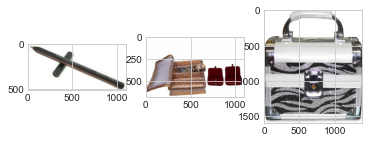

Computers


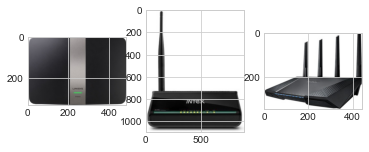

In [67]:
# Affichage d'exemples d'images par label
def list_fct(name):
    list_image_name = [df_images['image'][i] for i in range(len(df_images))
                       if df_images['Catégorie'][i] == name]
    return list_image_name


for name in Categories:
    print(name)

    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

[Retour au sommaire](#Sommaire)
### Nettoyage des images <a class="anchor" id="Partie2_2"></a>

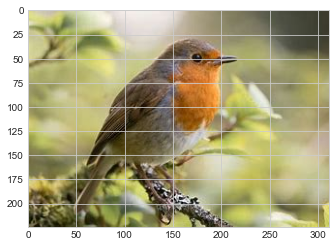

In [108]:
name = 'oiseau.jpg'
img = Image.open(name)
plt.imshow(img)

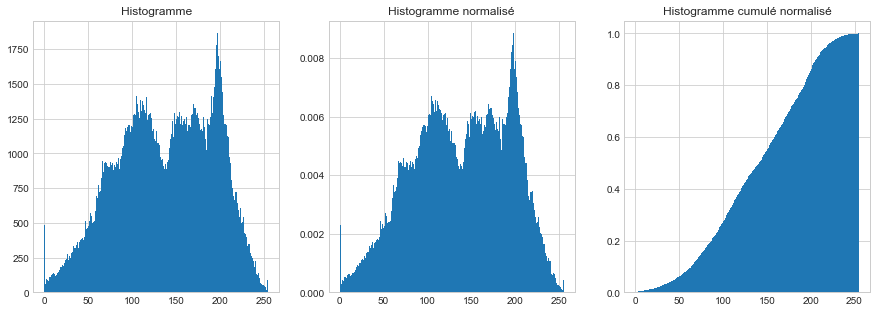

In [109]:
img_array = np.array(img)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(img_array.flatten(), bins=range(256))
plt.title('Histogramme')

plt.subplot(1, 3, 2)
plt.hist(img_array.flatten(), bins=range(256), density=True)
plt.title('Histogramme normalisé')

plt.subplot(1, 3, 3)
plt.hist(img_array.flatten(), bins=range(256), density=True, cumulative=True)
plt.title('Histogramme cumulé normalisé')

plt.show()

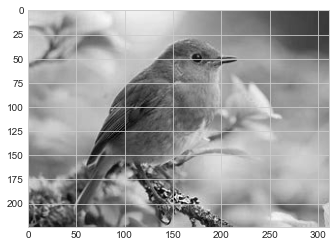

In [116]:
gray_img = img.convert('L')
gray_img_array = np.asarray(gray_img)
plt.imshow(gray_img_array, cmap='gray')
plt.show()

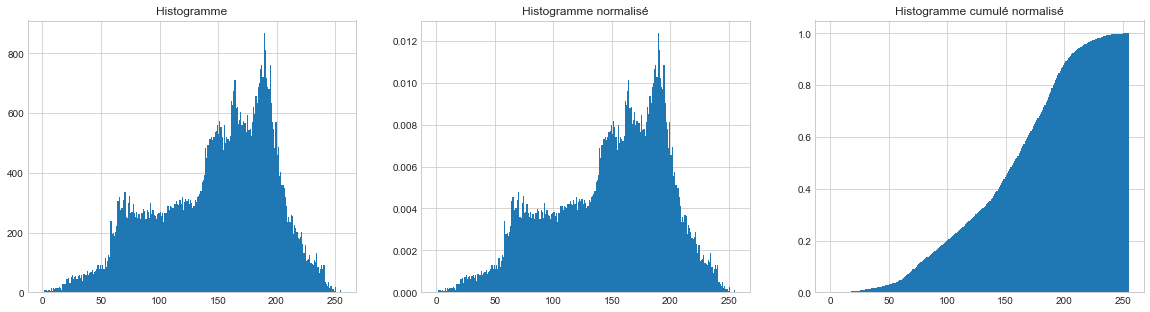

In [117]:
# Affichage des histogrammes
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(gray_img_array.flatten(), bins=range(256))
plt.title('Histogramme')

plt.subplot(1, 3, 2)
plt.hist(gray_img_array.flatten(), bins=range(256), density=True)
plt.title('Histogramme normalisé')

plt.subplot(1, 3, 3)
plt.hist(gray_img_array.flatten(), bins=range(256), density=True,
         cumulative=True)
plt.title('Histogramme cumulé normalisé')

plt.show()

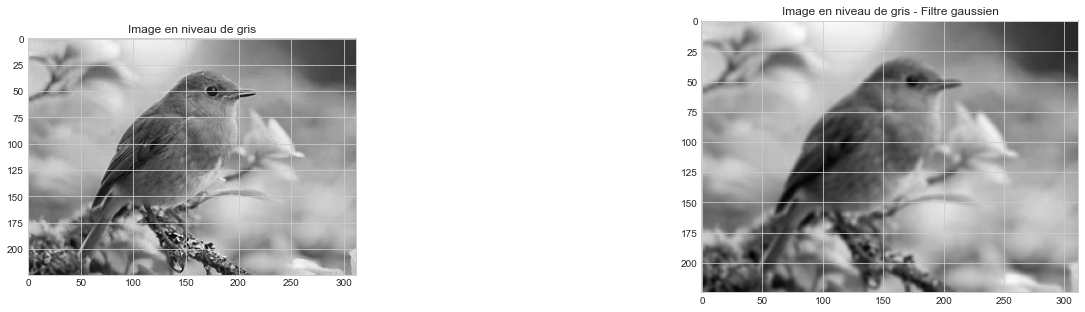

In [119]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Image en niveau de gris')

# Filtre Moyenneur
img_moy = gray_img.filter(ImageFilter.BoxBlur(1))
# On filtre l'image avec un filtre moyenneur qui prend
# 1 pixel dans chaque direction (9 pixels dans le filtre)
img_moy_array = np.array(img_moy)

# Filtre Gaussien
img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))
img_gauss_array = np.array(img_gauss)
plt.subplot(1, 2, 2)
plt.imshow(img_gauss, cmap='gray')
plt.title('Image en niveau de gris - Filtre gaussien')

plt.show()

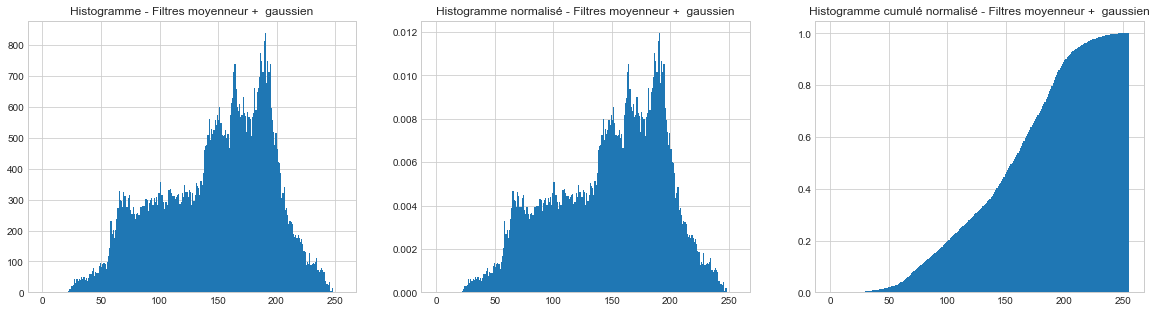

In [120]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(img_gauss_array.flatten(), bins=range(256))
plt.title('Histogramme - Filtres moyenneur +  gaussien')

plt.subplot(1, 3, 2)
plt.hist(img_gauss_array.flatten(), bins=range(256), density=True)
plt.title('Histogramme normalisé - Filtres moyenneur +  gaussien')

plt.subplot(1, 3, 3)
plt.hist(img_gauss_array.flatten(), bins=range(256), density=True,
         cumulative=True)
plt.title('Histogramme cumulé normalisé - Filtres moyenneur +  gaussien')

plt.show()

### Etirement et égalisation de l'histogramme

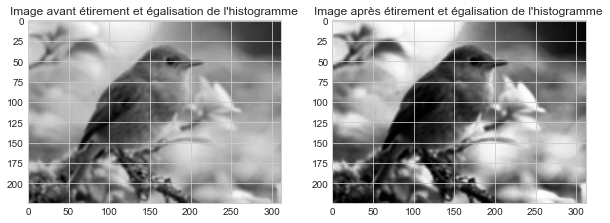

In [122]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_gauss, cmap='gray')
plt.title('Image avant étirement et égalisation de l\'histogramme')

img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
img_finale_array = np.array(img_finale)
plt.subplot(1, 2, 2)
plt.imshow(img_finale, cmap='gray')
plt.title('Image après étirement et égalisation de l\'histogramme')


plt.show()

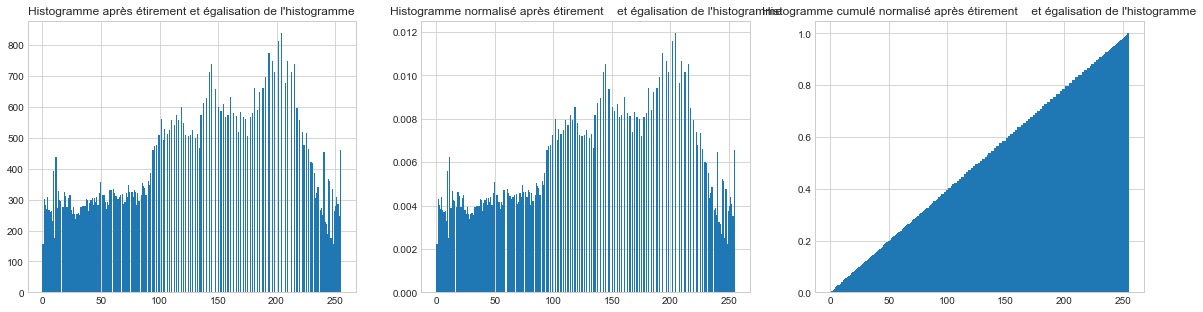

In [123]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(img_finale_array.flatten(), bins=range(256))
plt.title('Histogramme après étirement et égalisation de l\'histogramme')

plt.subplot(1, 3, 2)
plt.hist(img_finale_array.flatten(), bins=range(256), density=True)
plt.title('Histogramme normalisé après étirement\
    et égalisation de l\'histogramme')

plt.subplot(1, 3, 3)
plt.hist(img_finale_array.flatten(), bins=range(256), density=True,
         cumulative=True)
plt.title('Histogramme cumulé normalisé après étirement\
    et égalisation de l\'histogramme')

plt.show()

[Retour au sommaire](#Sommaire)
### SIFT<a class="anchor" id="Partie2_3"></a>

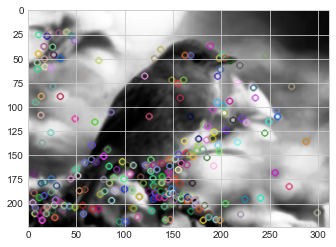

Descripteurs :  (266, 128)

[[  0.   0.   0. ...  14.  63. 126.]
 [  1.   0.   0. ...   0.   0.   5.]
 [  1.   1.   0. ...   0.   0.   0.]
 ...
 [138.  14.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   1.  15.]
 [  1.  60. 135. ...   0.   0.   0.]]


In [76]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img_finale_array, None)
img = cv2.drawKeypoints(img_finale_array, kp, img_finale_array)
                        # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [128]:
df_images.head()

image        Catégorie  Catégorie Numérique
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing                    4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care                    0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care                    0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing                    4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing                    4

In [129]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    name = path + df_images.iloc[image_num, 0]
    img = Image.open(name)
    gray_img = img.convert('L')

    img_moy = gray_img.filter(ImageFilter.BoxBlur(1))
    img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))

    img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
    img_redim = cv2.resize(np.array(img_finale), (224, 224),
                           interpolation=cv2.INTER_AREA)

    kp, des = sift.detectAndCompute(img_redim, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1,
      "secondes")


Nombre de descripteurs :  (337343, 128)
Temps de traitement SIFT descriptor :            65.25 secondes


In [151]:
# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print("Temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  581
Création de 581 clusters de descripteurs ...
Temps de traitement kmeans :             5.22 secondes


In [152]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0: print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

Temps de création histogrammes :            63.05 secondes


Dimensions dataset avant réduction ACP :  (1050, 581)


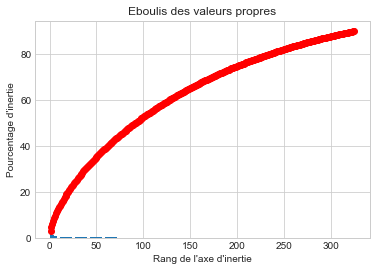

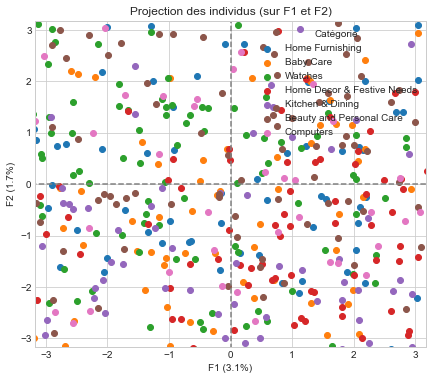

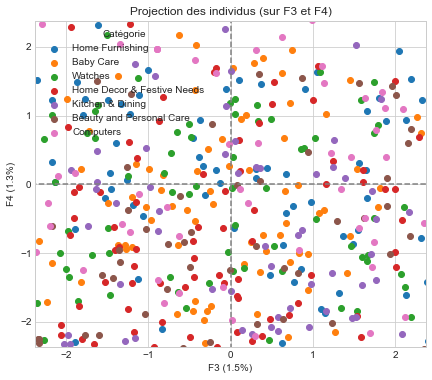

Dimensions dataset après réduction ACP :  (1050, 325)


In [153]:
im_features = pd.DataFrame(im_features)
print("Dimensions dataset avant réduction ACP : ", im_features.shape)
im_features['Catégorie'] = df_['Catégorie']
features_SIFT = ACP(im_features)
print("Dimensions dataset après réduction ACP : ", features_SIFT.shape)

In [154]:
features_SIFT.head()

0         1         2         3         4         5         6    \
0  -1.694118  8.169710  1.316890 -1.581218 -0.048030 -1.153260 -5.505141   
1   1.757632 -0.586050 -0.010658  4.700867  0.057505 -1.799714 -3.936774   
2  -4.107834  7.300605 -0.214700 -4.340026  4.821113 -0.363845  1.508637   
3  14.611167 -1.077723 -1.512834  7.547587  3.281487 -0.687799  0.312600   
4   9.574807 -4.303527 -3.272441  5.446688  7.060239  0.093365 -6.406005   

        7         8         9    ...       315       316       317       318  \
0 -2.394381  1.335895  0.992768  ...  0.273153  0.735654 -0.266385 -0.868272   
1  0.977324 -0.289927 -0.544546  ... -1.508108  0.384464  0.579524 -1.074978   
2 -3.373181 -4.217750  3.018826  ...  0.201597 -0.215898  0.151314 -0.486368   
3  0.111015 -0.772088  0.666602  ...  0.400117 -0.047547 -0.116568 -1.140904   
4  0.512585 -0.262713 -1.208682  ... -0.601843 -0.708372  0.582078  0.731116   

        319       320       321       322       323       324  
0  0.140551 -0.824044  0.564194  1.234012  0.852787 -0.593228  
1 -0.824381  0.701092 -1.694477  1.255602 -0.381755  0.389823  
2 -1.794162  0.218965 -0.685029 -0.521844  1.471210  0.915166  
3  0.305040 -0.848406 -0.205568  0.716010 -1.630526  0.142362  
4 -0.315462 -0.546639  0.800104  1.160261 -0.246309 -0.051979  

[5 rows x 325 columns]

ARI : 0.039591261154882394


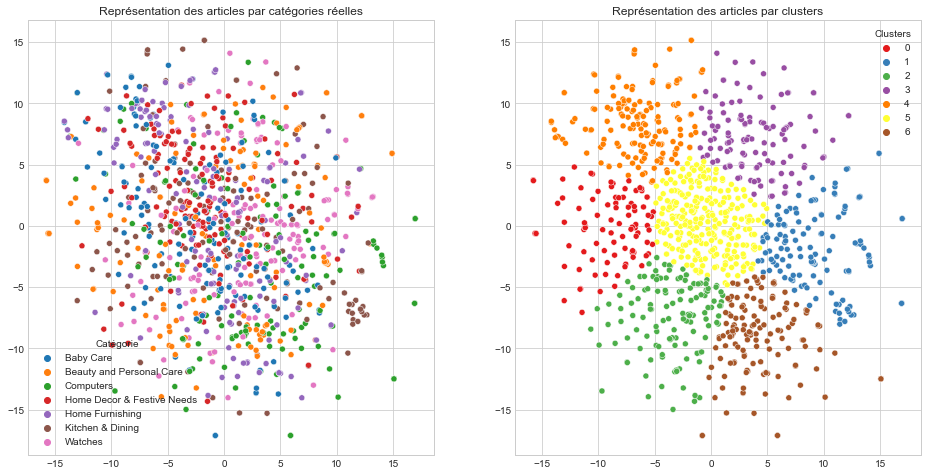

In [155]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_SIFT = tsne.fit_transform(features_SIFT)
ARI_SIFT, labels_SIFT = ARI(X_tsne_SIFT, df_images)
AfficheClusters(X_tsne_SIFT, df_images, labels_SIFT)

[Retour au sommaire](#Sommaire)

### ORB <a class="anchor" id="Partie2_4"></a>

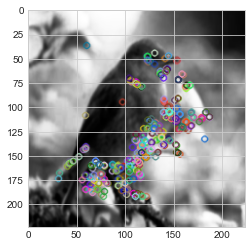

Descripteurs :  (384, 32)

[[ 81 205  31 ... 179 224  40]
 [216 147  30 ...  11 133  35]
 [166 238 132 ...  92 131 143]
 ...
 [210 252 189 ...  88 135 123]
 [175 223  67 ... 255 248 213]
 [ 37 253  83 ... 251 226 185]]


In [156]:
orb = cv2.ORB_create(500)
img_redim = cv2.resize(img_finale_array, (224, 224),
                       interpolation=cv2.INTER_AREA)
kp, des = orb.detectAndCompute(np.array(img_redim), None)
img = cv2.drawKeypoints(img_redim, kp, img_redim)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [157]:
# identification of key points and associated descriptors
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create(500)
indexes = []

for image_num in range(len(list_photos)):
    name = path + df_images.iloc[image_num, 0]
    img = Image.open(name)
    gray_img = img.convert('L')

    img_moy = gray_img.filter(ImageFilter.BoxBlur(1))
    img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))

    img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
    img_redim = np.array(img_finale)

    kp, des = orb.detectAndCompute(img_redim, None)
    if des is not None:
        orb_keypoints.append(des)
        indexes.append(image_num)

orb_keypoints_by_img = np.asarray(orb_keypoints)
print(orb_keypoints_by_img.shape)

orb_keypoints_all = np.concatenate(orb_keypoints_by_img, axis=0)

print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement ORB descriptor : ", "%15.2f" % duration1,
      "secondes")

(1050,)
Nombre de descripteurs :  (516204, 32)
Temps de traitement ORB descriptor :            71.61 secondes


In [158]:
# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1 = time.time() - temps1
print("Temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  718
Création de 718 clusters de descripteurs ...
Temps de traitement kmeans :             7.92 secondes


In [159]:
# Creation of histograms (features)
temps1 = time.time()

# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(orb_keypoints_by_img):
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features_ORB = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

Temps de création histogrammes :            69.78 secondes


Dimensions dataset avant réduction ACP :  (1050, 718)


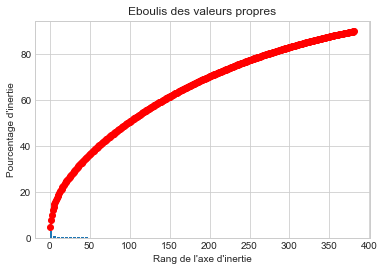

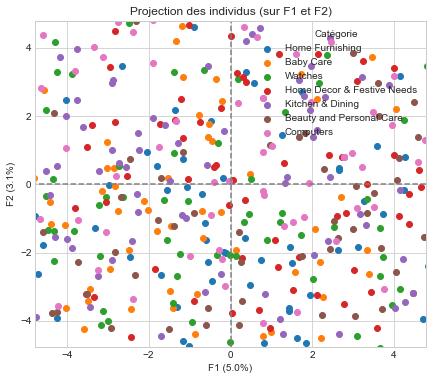

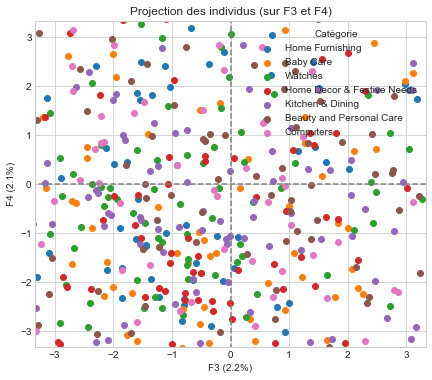

Dimensions dataset après réduction ACP :  (1050, 381)


In [160]:
im_features_ORB = pd.DataFrame(im_features_ORB)
print("Dimensions dataset avant réduction ACP : ", im_features_ORB.shape)
im_features_ORB['Catégorie'] = df_['Catégorie']
features_ORB = ACP(im_features_ORB)
print("Dimensions dataset après réduction ACP : ", features_ORB.shape)

In [161]:
features_ORB.head()

0         1         2         3         4         5         6    \
0  10.911844  2.659875 -0.309254 -4.668809  6.138485  0.340708 -0.685964   
1   6.958489 -5.934242  2.170936 -2.124358  2.763430  6.117680  0.363320   
2  -0.770214  2.025824  1.194090 -5.172598 -4.164821  0.701462 -6.362596   
3   8.700630 -4.128078  5.873647 -0.784271  1.799133 -0.436663 -2.390445   
4   1.613524 -4.489513  1.004820 -2.434079  3.188379 -0.154248 -2.102573   

        7         8          9    ...       371       372       373       374  \
0  0.242957  1.108250   1.198449  ...  0.080356  0.438365  0.092417  0.531226   
1  3.058856  2.657985   2.621992  ...  0.193020  0.119965 -0.536880  0.379092   
2 -2.217991 -1.824979 -11.325866  ... -0.965367  0.159227  0.542646  0.581014   
3  1.092643  1.131857   0.667789  ...  0.548437 -0.221481  0.910812  0.298025   
4 -0.528744  0.129824   1.881177  ...  0.337788  0.350316  0.019842 -0.438893   

        375       376       377       378       379       380  
0 -0.071212 -0.806335  0.207814 -1.559858  0.249600 -0.214965  
1  0.677598  0.457477 -0.065300 -0.659632  0.149010 -0.245874  
2 -0.245024  0.410147  1.071718 -1.162561 -0.246798 -0.334151  
3 -0.360571  0.144327 -0.160578  1.321397  0.393152  0.546363  
4  0.751819 -0.765180 -1.056085 -1.164071 -0.277548 -0.305627  

[5 rows x 381 columns]

ARI : 0.023273664039071683


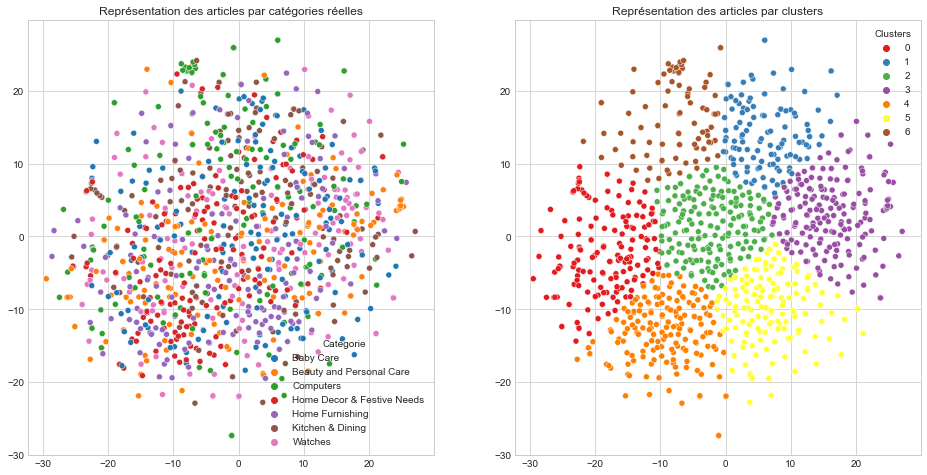

In [162]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_ORB = tsne.fit_transform(features_ORB)
ARI_ORB, labels_ORB = ARI(X_tsne_ORB, df_images.iloc[indexes, :])
AfficheClusters(X_tsne_ORB, df_images.iloc[indexes, :], labels_ORB)

[Retour au sommaire](#Sommaire)

### CNN <a class="anchor" id="Partie2_5"></a>

* [VGG16](#PartieI)
* [ResNet50](#PartieJ)
* [InceptionV3](#PartieK)

#### VGG16 <a class="anchor" id="PartieI"></a>

In [89]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [90]:
temps1 = time.time()
features_VGG = []

for image_num in range(len(list_photos)):
    name = path + df_images.iloc[image_num, 0]
    img = Image.open(name)

    img_moy = img.filter(ImageFilter.BoxBlur(1))
    img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))

    img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
    img_redim = cv2.resize(np.array(img_finale), (224, 224),
                           interpolation=cv2.INTER_AREA)

    image = img_redim.reshape((1, img_redim.shape[0],
                               img_redim.shape[1], img_redim.shape[2]))
    image = prepVGG(image)
    features = model.predict(image)

    if image_num == 0:
        features_VGG = features
    else:
        features_VGG = np.concatenate((features_VGG, features))

duration1 = time.time() - temps1
print("Temps de traitement Tranfer Learning : ", "%15.2f" % duration1,
      "secondes")

1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 330ms/step
Temps de traitement Tranfer Learning :           778.67 secondes


In [91]:
print("Dimensions dataset avant réduction PCA : ", features_VGG.shape)
pca = decomposition.PCA(n_components=0.90)
features_pca_VGG = pca.fit_transform(features_VGG)
print("Dimensions dataset après réduction PCA : ", features_pca_VGG.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 305)


ARI : 0.4935465962681692


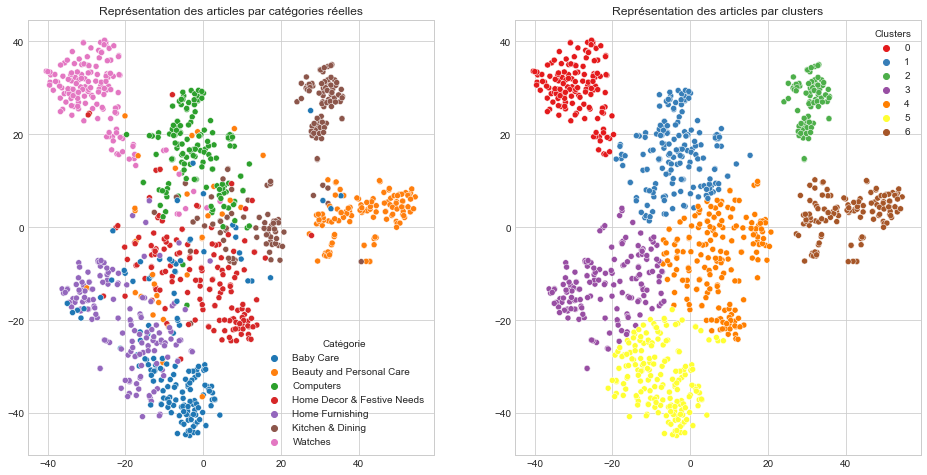

In [92]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_VGG = tsne.fit_transform(features_pca_VGG)
ARI_VGG, labels_VGG = ARI(X_tsne_VGG, df_)
AfficheClusters(X_tsne_VGG, df_, labels_VGG)

[Retour au sommaire - CNN](#Partie2_5)

#### ResNet50 <a class="anchor" id="PartieJ"></a>

In [93]:
# load model
model = ResNet50()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [94]:
temps1 = time.time()
features_ResNet = []

for image_num in range(len(list_photos)):
    name = path + df_images.iloc[image_num, 0]
    img = Image.open(name)

    img_moy = img.filter(ImageFilter.BoxBlur(1))
    img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))

    img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
    img_redim = cv2.resize(np.array(img_finale), (224, 224), interpolation=cv2.INTER_AREA)

    image = img_redim.reshape((1, img_redim.shape[0], img_redim.shape[1], img_redim.shape[2]))
    image = prepResNet(image)
    features = model.predict(image)

    if image_num == 0:
        features_ResNet = features
    else:
        features_ResNet = np.concatenate((features_ResNet, features))

duration1 = time.time() - temps1
print("Temps de traitement Tranfer Learning : ", "%15.2f" % duration1,
      "secondes")

1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 191ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 115ms/step
Temps de traitement Tranfer Learning :           609.86 secondes


In [95]:
print("Dimensions dataset avant réduction PCA : ", features_ResNet.shape)
pca = decomposition.PCA(n_components=0.90)
features_pca_ResNet = pca.fit_transform(features_ResNet)
print("Dimensions dataset après réduction PCA : ", features_pca_ResNet.shape)

Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 273)


ARI : 0.5170537240559826


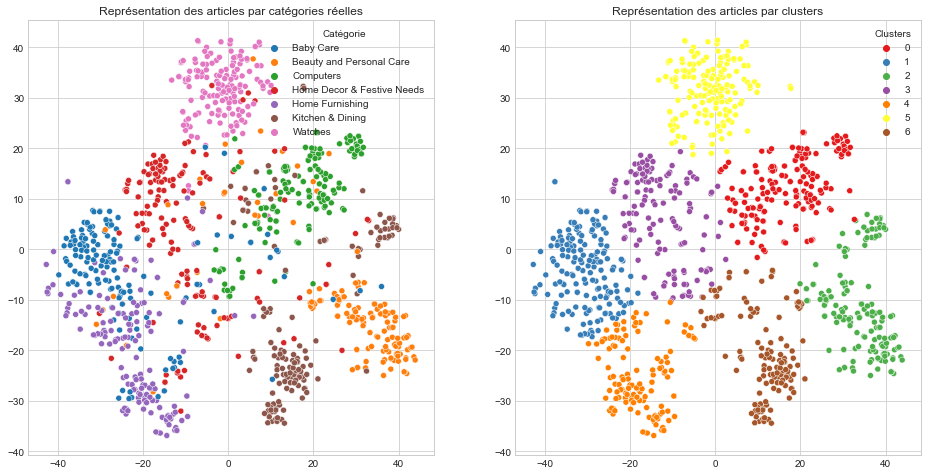

In [96]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_ResNet = tsne.fit_transform(features_pca_ResNet)
ARI_ResNet, labels_ResNet = ARI(X_tsne_ResNet, df_)
AfficheClusters(X_tsne_ResNet, df_, labels_ResNet)

[Retour au sommaire - CNN](#Partie2_5)

#### InceptionV3 <a class="anchor" id="PartieK"></a>

In [97]:
# load model
model = InceptionV3()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [98]:
temps1 = time.time()
features_Inc = []

for image_num in range(len(list_photos)):
    name = path + df_images.iloc[image_num, 0]
    img = Image.open(name)

    img_moy = img.filter(ImageFilter.BoxBlur(1))
    img_gauss = img_moy.filter(ImageFilter.GaussianBlur(1))

    img_finale = ImageOps.equalize(ImageOps.autocontrast(img_gauss))
    img_redim = cv2.resize(np.array(img_finale), (299, 299), interpolation=cv2.INTER_AREA)

    image = img_redim.reshape((1, img_redim.shape[0], img_redim.shape[1], img_redim.shape[2]))
    image = prepInc(image)
    features = model.predict(image)

    if image_num == 0:
        features_Inc = features
    else:
        features_Inc = np.concatenate((features_Inc, features))

duration1 = time.time() - temps1
print("Temps de traitement Tranfer Learning : ", "%15.2f" % duration1,
      "secondes")

1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 803ms/step


1/1 [==============================] - 0s 192ms/step
Temps de traitement Tranfer Learning :           837.90 secondes


In [99]:
print("Dimensions dataset avant réduction PCA : ", features_Inc.shape)
pca = decomposition.PCA(n_components=0.90)
features_pca_Inc = pca.fit_transform(features_Inc)
print("Dimensions dataset après réduction PCA : ", features_pca_Inc.shape)

Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 285)


ARI : 0.611426528204058


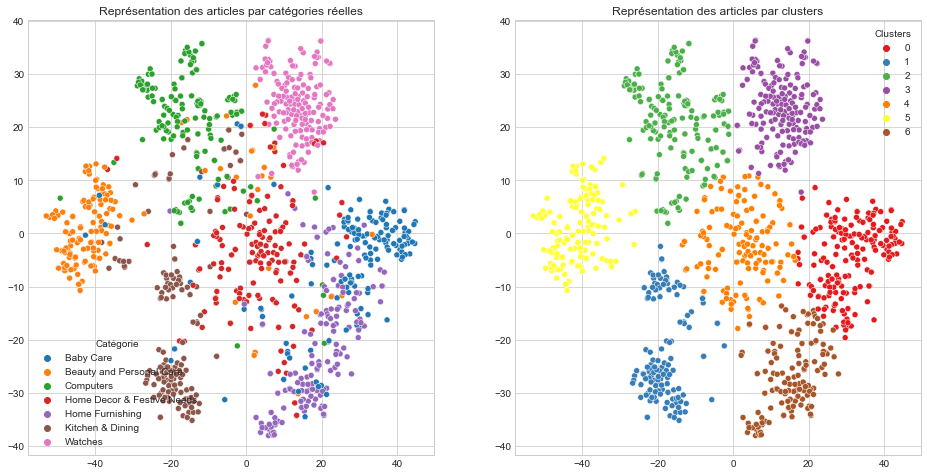

In [100]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_Inc = tsne.fit_transform(features_pca_Inc)
ARI_Inc, labels_Inc = ARI(X_tsne_Inc, df_)
AfficheClusters(X_tsne_Inc, df_, labels_Inc)

[Retour au sommaire](#Sommaire)

### Comparaison des performances <a class="anchor" id="Partie2_6"></a>

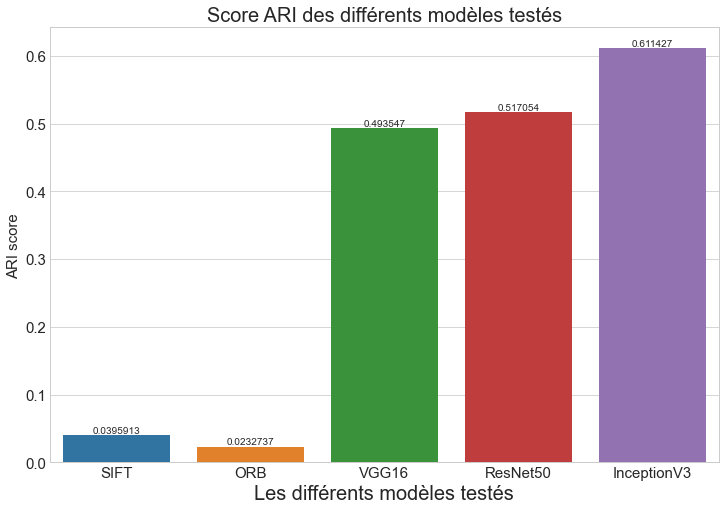

In [163]:
listeARI = [ARI_SIFT, ARI_ORB,
            ARI_VGG, ARI_ResNet, ARI_Inc]
listeModeles = ['SIFT', 'ORB',
                'VGG16', 'ResNet50', 'InceptionV3']

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x=listeModeles, y=listeARI)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Score ARI des différents modèles testés',
          fontsize=20)
plt.xlabel('Les différents modèles testés', fontsize=20)
plt.ylabel('ARI score', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xticks(rotation=45)
plt.show()

[Retour au sommaire](#Sommaire)

### Données textuelles + données visuelles <a class="anchor" id="Partie3"></a>

In [102]:
df_texte_images = pd.DataFrame(features_USE2).join(
    pd.DataFrame(features_Inc), lsuffix='_texte')

In [103]:
print(df_texte_images.shape)
df_texte_images.head()

(1050, 2560)


0_texte   1_texte   2_texte   3_texte   4_texte   5_texte   6_texte  \
0 -0.025043  0.046877 -0.000435 -0.039334 -0.014154  0.034265 -0.007763   
1  0.025044  0.075354 -0.044747  0.015103 -0.013375  0.071453  0.050270   
2 -0.076130  0.076240  0.030752 -0.000588  0.032630  0.091077  0.059895   
3  0.007227  0.038710 -0.037985  0.059118 -0.023267  0.044127  0.012136   
4  0.054258  0.059756 -0.077240  0.053643  0.005222  0.099507 -0.034504   

    7_texte   8_texte   9_texte  ...      2038      2039      2040      2041  \
0  0.032929 -0.019433 -0.007239  ...  0.141973  0.053534  0.122838  0.779508   
1  0.021235  0.011593 -0.021968  ...  0.055363  0.502144  0.022736  0.004563   
2 -0.022883  0.021149  0.039910  ...  0.343722  0.040274  0.323418  0.110108   
3 -0.000609  0.027535 -0.012722  ...  0.371852  1.253352  0.125782  0.185556   
4 -0.042555 -0.040953 -0.005922  ...  0.661063  0.266806  0.259716  0.468209   

       2042      2043      2044      2045      2046      2047  
0  0.677704  1.910986  0.577257  0.618898  1.035613  0.169679  
1  0.856335  0.159395  0.016594  0.115727  0.000000  0.000000  
2  0.187055  0.181267  0.736062  0.208529  0.475313  0.022795  
3  0.290216  0.030434  0.082953  0.042928  0.062644  0.126129  
4  0.401063  0.769131  0.800673  0.040101  0.097007  0.956610  

[5 rows x 2560 columns]

In [104]:
print("Dimensions dataset avant réduction PCA : ", df_texte_images.shape)
pca = decomposition.PCA(n_components=0.90)
features_pca = pca.fit_transform(df_texte_images.values)
print("Dimensions dataset après réduction PCA : ", features_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2560)
Dimensions dataset après réduction PCA :  (1050, 288)


ARI : 0.5825630835476596


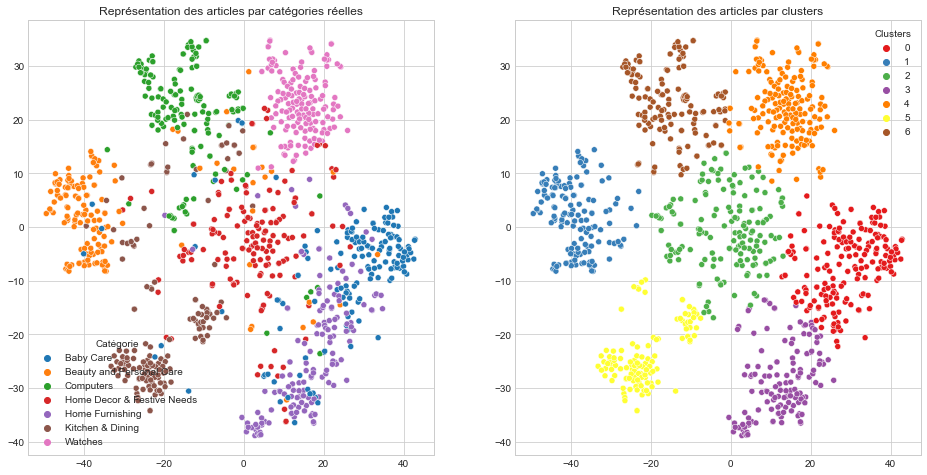

In [105]:
# t-sne
tsne = TSNE(n_components=2, init='pca', n_jobs=-1, random_state=6)
X_tsne_CNN = tsne.fit_transform(features_pca)
ARI_CNN, labels_CNN = ARI(X_tsne_CNN, df_)
AfficheClusters(X_tsne_CNN, df_, labels_CNN)